<div style="text-align:center">

**<font color="#34d5eb">Ahmadreza Majlesara</font>**

**<font color="#34d5eb">StudentID: 400101861</font>**

**<font color="#34d5eb"> Assignment 2</font>**

**<font color="#34d5eb">data networks Dr.Pakravan</font>**


</div>

part 1

imprts

In [40]:
import numpy as np
import random
from zlib import crc32
import random
import matplotlib.pyplot as plt


class of transciever

In [41]:

class Transceiver:
    def __init__(self):
        self.original_streams = []
        self.scrambled_streams = []
        self.crc_appended_streams = []
        self.poly = 0xEDB88320

    def generate_random_stream(self, length):
        """Generate a random binary stream of specified length."""
        return np.random.randint(0, 2, size=length).astype(np.uint8)
    
    def scramble_stream(self, stream):
        """Scramble a binary stream to even out the number of 1s and 0s."""
        scrambled = stream.copy()
        num_ones = np.sum(scrambled)
        total_bits = len(scrambled)
        desired_ones = total_bits // 2
        desired_zeros = total_bits - desired_ones

        if num_ones > desired_ones:
            # Too many ones, need to flip some ones to zeros
            indices_to_flip = np.random.choice(np.where(scrambled == 1)[0], num_ones - desired_ones, replace=False)
            scrambled[indices_to_flip] = 0
        elif num_ones < desired_ones:
            # Too few ones, need to flip some zeros to ones
            indices_to_flip = np.random.choice(np.where(scrambled == 0)[0], desired_zeros - num_ones, replace=False)
            scrambled[indices_to_flip] = 1

        return scrambled
    
    def process_stream(self, length):
        """Generate, scramble, and append CRC to a binary stream without returning."""
        original = self.generate_random_stream(length)
        scrambled = self.scramble_stream(original)
        crc_appended = self.append_crc32(scrambled)
        
        self.original_streams.append(original)
        self.scrambled_streams.append(scrambled)
        self.crc_appended_streams.append(crc_appended)
        
    def get_streams(self):
        """Return stored original, scrambled, and CRC-appended streams."""
        return (self.original_streams, self.scrambled_streams, self.crc_appended_streams)

    def format_stream(self, streams):
        """Format the streams as strings of binary numbers."""
        return [''.join(str(bit) for bit in stream) for stream in streams]

    def compute_crc32(self, data):
        """Compute the CRC-32 checksum."""
        crc = 0xFFFFFFFF
        for byte in np.packbits(data):
            crc ^= byte
            for _ in range(8):
                if (crc & 1):
                    crc = (crc >> 1) ^ self.poly
                else:
                    crc >>= 1
        return crc ^ 0xFFFFFFFF

    def append_crc32(self, stream):
        """Append the CRC-32 checksum to a binary stream."""
        crc = self.compute_crc32(stream)
        crc_bits = np.unpackbits(np.array([crc], dtype=np.uint32).view(np.uint8))
        return np.concatenate((stream, crc_bits))



class Receiver:
    def __init__(self):
        self.valid_streams = []

    def check_crc(self, stream):
        """Check if the received stream has a valid CRC."""
        # Assume the last 32 bits are the CRC
        data, received_crc = stream[:-32], stream[-32:]
        recalculated_crc = self.compute_crc32(data)

        # Check if recalculated CRC matches the received CRC
        for i in range(len(received_crc)):
            if received_crc[i] != np.unpackbits(np.array([recalculated_crc], dtype=np.uint32).view(np.uint8))[i]:

                return False
        return True

    def compute_crc32(self, data):
        """Compute the CRC-32 checksum, similar to the Transceiver."""
        poly = 0xEDB88320
        crc = 0xFFFFFFFF
        for byte in np.packbits(data):
            crc ^= byte
            for _ in range(8):
                if (crc & 1):
                    crc = (crc >> 1) ^ poly
                else:
                    crc >>= 1
        return crc ^ 0xFFFFFFFF

    def add_stream(self, stream):
        """Add a valid stream to the list of valid streams."""
        if self.check_crc(stream):
            self.valid_streams.append(stream)
            return True
        return False



a code to generate a 16 bit stream and scramble it and generate CRC for that

In [42]:
transceiver = Transceiver()
transceiver.process_stream(20)
(originals, scrambles, crcs) = transceiver.get_streams()

print("Original Stream: [", transceiver.format_stream(originals), "]")
print("Scrambled Stream: [", transceiver.format_stream(scrambles), "]")
print("CRC Appended Stream: [", transceiver.format_stream(crcs), "]")

Original Stream: [ ['11101101110001101010'] ]
Scrambled Stream: [ ['11101101000001101010'] ]
CRC Appended Stream: [ ['1110110100000110101010001111100111101111011111011110'] ]


code to validate the CRC appended stream using built-in methods

In [43]:
stream = scrambles[0]
data_bytes = np.packbits(stream)
crc = crc32(data_bytes)
crc_bits = np.unpackbits(np.array([crc], dtype=np.uint32).view(np.uint8))
extended_stream = np.concatenate((stream, crc_bits))

print(extended_stream)


[1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0]


validating for 100 random 50 bit streams

In [44]:
match_count = 0
for _ in range(100):
    transceiver.process_stream(50)
    originals, scrambles, crcs = transceiver.get_streams()

    # Manual CRC calculation for last scrambled stream
    stream = scrambles[-1]
    data_bytes = np.packbits(stream)
    crc = crc32(data_bytes)
    crc_bits = np.unpackbits(np.array([crc], dtype=np.uint32).view(np.uint8))
    extended_stream = np.concatenate((stream, crc_bits))

    # Check if the manually extended stream matches the one from the class
    if np.array_equal(crcs[-1], extended_stream):
        match_count += 1

print(f"Number of matches: {match_count} out of 100 iterations")

Number of matches: 100 out of 100 iterations


a code to see functionallity of reciever

In [45]:
receiver = Receiver()
transceiver = Transceiver()
transceiver.process_stream(10)
transceiver.process_stream(10)
(originals, scrambles, crcs) = transceiver.get_streams()
received_streams = transceiver.crc_appended_streams  # Simulating receiving streams that were sent
received_streams[0][0] = 1 - received_streams[0][0]
for stream in received_streams:
    if receiver.add_stream(stream):
        print("Stream added successfully, CRC is valid.")
    else:
        print("Stream rejected, CRC is invalid.")

Stream rejected, CRC is invalid.
Stream added successfully, CRC is valid.


code to generate 1000 arrays of data and send them with error probability of 0.2-0.8 to have change in 1 random bit

In [46]:
def simulate_transmissions(transceiver, receiver, num_streams, stream_length, error_probabilities):
    total_transmissions = 0
    num_mismatches = 0
    num_truetrans = 0
    
    for error_prob in error_probabilities:
        i=0
        max_miss = 0
        while i < num_streams:

            transceiver.process_stream(stream_length)
            # Get the last transmitted stream
            stream = transceiver.crc_appended_streams[i]

            # Introduce error with a given probability
            if random.random() < error_prob and max_miss < 10:
                bit_to_flip = random.randint(0, len(stream) - 33)  # excluding the CRC bits
                stream[bit_to_flip] = 1 - stream[bit_to_flip]  # Flip the bit

            # Transmit and check
            valid = receiver.add_stream(stream)
            total_transmissions += 1
            if not valid:
                num_mismatches += 1
                max_miss += 1
            
            if valid or max_miss > 10:
                if valid:
                    num_truetrans += 1
                i = i + 1
                max_miss = 0

    return total_transmissions, num_mismatches , num_truetrans


simulation of the above block

In [47]:
sec_receiver = Receiver()
sec_transceiver = Transceiver()

total_transmissions1, num_mismatches1 , num_truetrans1 = simulate_transmissions(
    sec_transceiver,
    sec_receiver,
    1000,
    100,
    [0.2]
)

total_transmissions2, num_mismatches2 , num_truetrans2 = simulate_transmissions(
    sec_transceiver,
    sec_receiver,
    1000,
    100,
    [0.4]
)

total_transmissions3, num_mismatches3 ,num_truetrans3= simulate_transmissions(
    sec_transceiver,
    sec_receiver,
    1000,
    100,
    [0.6]
)

total_transmissions4, num_mismatches4 ,num_truetrans4= simulate_transmissions(
    sec_transceiver,
    sec_receiver,
    1000,
    100,
    [0.8]
)

total_transmissions5, num_mismatches5 ,num_truetrans5 = simulate_transmissions(
    sec_transceiver,
    sec_receiver,
    1000,
    100,
    [0.95]
)
print(f"Total Transmissions: {total_transmissions1}")
print(f"Number of Mismatches (requiring retransmissions): {num_mismatches1}")
print(f"Number of True Transmissions: {num_truetrans1}")

print(f"Total Transmissions: {total_transmissions2}")
print(f"Number of Mismatches (requiring retransmissions): {num_mismatches2}")
print(f"Number of True Transmissions: {num_truetrans2}")

print(f"Total Transmissions: {total_transmissions3}")
print(f"Number of Mismatches (requiring retransmissions): {num_mismatches3}")
print(f"Number of True Transmissions: {num_truetrans3}")

print(f"Total Transmissions: {total_transmissions4}")
print(f"Number of Mismatches (requiring retransmissions): {num_mismatches4}")
print(f"Number of True Transmissions: {num_truetrans4}")

print(f"Total Transmissions: {total_transmissions5}")
print(f"Number of Mismatches (requiring retransmissions): {num_mismatches5}")
print(f"Number of True Transmissions: {num_truetrans5}")

Total Transmissions: 3155
Number of Mismatches (requiring retransmissions): 2370
Number of True Transmissions: 785
Total Transmissions: 6318
Number of Mismatches (requiring retransmissions): 5849
Number of True Transmissions: 469
Total Transmissions: 9176
Number of Mismatches (requiring retransmissions): 8993
Number of True Transmissions: 183
Total Transmissions: 10602
Number of Mismatches (requiring retransmissions): 10562
Number of True Transmissions: 40
Total Transmissions: 11000
Number of Mismatches (requiring retransmissions): 11000
Number of True Transmissions: 0


plottting of data that have been generated in above block

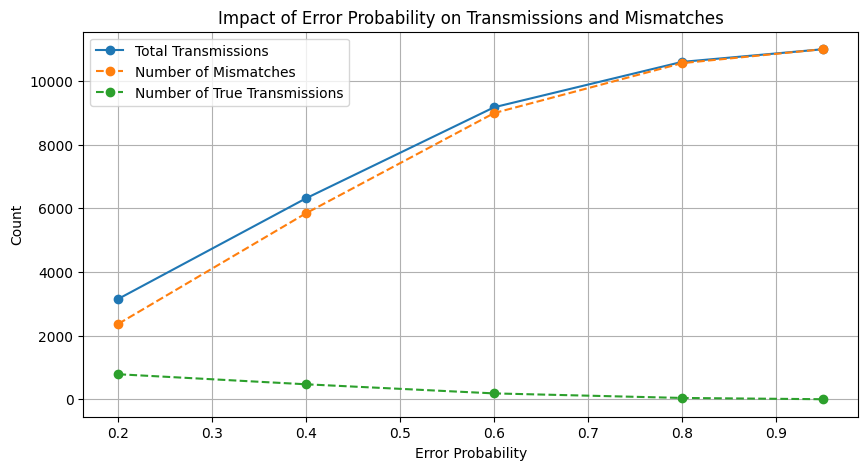

In [48]:

# Probabilities tested
error_probs = [0.2, 0.4, 0.6, 0.8,0.95]

# Total transmissions for each probability
total_transmissions = [total_transmissions1, total_transmissions2, total_transmissions3, total_transmissions4, total_transmissions5]

# Number of mismatches (requiring retransmissions) for each probability
num_mismatches = [num_mismatches1, num_mismatches2, num_mismatches3, num_mismatches4 , num_mismatches5]

num_truetransmissions = [num_truetrans1, num_truetrans2, num_truetrans3, num_truetrans4, num_truetrans5]
# Creating the plot
plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(error_probs, total_transmissions, label='Total Transmissions', marker='o')

# Plotting number of mismatches
plt.plot(error_probs, num_mismatches, label='Number of Mismatches', marker='o', linestyle='--')

plt.plot(error_probs, num_truetransmissions, label='Number of True Transmissions', marker='o', linestyle='--')
# Adding titles and labels
plt.title('Impact of Error Probability on Transmissions and Mismatches')
plt.xlabel('Error Probability')
plt.ylabel('Count')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()


method to simulate selective repeat

In [49]:
def simulate_selective_repeat(transceiver, receiver, window_size, num_streams, stream_length, error_probability, max_attempts,number_of_flips):
    total_transmissions = 0
    num_mismatches = 0
    num_truetrans = 0
    
    # Initialize the frames in the transceiver
    if transceiver.crc_appended_streams.__len__() <= 0:
        for _ in range(num_streams):
            transceiver.process_stream(stream_length)

    original_streams = [stream.copy() for stream in transceiver.crc_appended_streams]  # Make a copy of the original streams

    acks = [False] * num_streams  # Track acknowledgment status
    attempts = [0] * num_streams  # Track transmission attempts for each frame

    smin = 0  # Start of the window
    smax = smin + window_size  # End of the window
    
    timeline=[]
    while smin < num_streams:
        print(f"\nWindow: {smin} to {min(smax, num_streams - 1)}")
        for j in range(smin, min(smax, num_streams)):
            print(f"Processing frame {j}: Acknowledged={acks[j]}, Attempts={attempts[j]}")
            if not acks[j] :  # Check if not acknowledged and less than max attempts
                if random.random() < error_probability:
                    flipped_bits = set()
                    stream = original_streams[j].copy()
                    while len(flipped_bits) < number_of_flips:
                        bit_to_flip = random.randint(0, stream_length)  # Ensure not flipping CRC bits
                        if bit_to_flip not in flipped_bits:
                            stream[bit_to_flip] = 1 - stream[bit_to_flip]
                            flipped_bits.add(bit_to_flip)
                            print(f"Error introduced in frame {j} at position {bit_to_flip}")

                else:
                    stream = original_streams[j].copy()

                # Transmitting the frame
                valid = receiver.add_stream(stream)
                total_transmissions += 1
                attempts[j] += 1
                
                if valid or attempts[j] > max_attempts:
                    timeline.append("Ack" + str(j))
                    acks[j] = True
                    num_truetrans += 1
                    print(f"Frame {j} transmitted successfully and acknowledged.")
                    print("Ack" + str(j))
                else:
                    timeline.append("Nack" + str(j))
                    num_mismatches += 1
                    print(f"Frame {j} transmission failed, retransmission required.")
                    print("Nack" + str(j))

        # Move the window
        while smin < num_streams and acks[smin]:
            print(f"Sliding window: Frame {smin} acknowledged.")
            smin += 1
            smax = smin + window_size

    return total_transmissions, num_mismatches, num_truetrans, acks , timeline




test of above method with error rate of 0.6 and max attempts of 100

In [50]:
transceiver = Transceiver()
receiver = Receiver()
# Adjusting the call to function based on correct error probability setup
total_transmissions, num_mismatches, num_truetrans, acks , timeline= simulate_selective_repeat(
    transceiver, receiver, 4, 10, 20, 0.6 , 100 , 1
)

print(f"\nTotal Transmissions: {total_transmissions}")
print(f"Number of Mismatches: {num_mismatches}")
print(f"Number of Successful Transmissions: {num_truetrans}")
print("Acknowledgment Status:", acks)
print("Timeline:", timeline)


Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 11
Frame 0 transmission failed, retransmission required.
Nack0
Processing frame 1: Acknowledged=False, Attempts=0
Frame 1 transmitted successfully and acknowledged.
Ack1
Processing frame 2: Acknowledged=False, Attempts=0
Error introduced in frame 2 at position 8
Frame 2 transmission failed, retransmission required.
Nack2
Processing frame 3: Acknowledged=False, Attempts=0
Error introduced in frame 3 at position 9
Frame 3 transmission failed, retransmission required.
Nack3

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=1
Error introduced in frame 0 at position 9
Frame 0 transmission failed, retransmission required.
Nack0
Processing frame 1: Acknowledged=True, Attempts=1
Processing frame 2: Acknowledged=False, Attempts=1
Frame 2 transmitted successfully and acknowledged.
Ack2
Processing frame 3: Acknowledged=False, Attempts=1
Frame 3 transmitted successfully and ack


Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Frame 0 transmitted successfully and acknowledged.
Ack0
Processing frame 1: Acknowledged=False, Attempts=0
Frame 1 transmitted successfully and acknowledged.
Ack1
Processing frame 2: Acknowledged=False, Attempts=0
Frame 2 transmitted successfully and acknowledged.
Ack2
Processing frame 3: Acknowledged=False, Attempts=0
Frame 3 transmitted successfully and acknowledged.
Ack3
Sliding window: Frame 0 acknowledged.
Sliding window: Frame 1 acknowledged.
Sliding window: Frame 2 acknowledged.
Sliding window: Frame 3 acknowledged.

Window: 4 to 8
Processing frame 4: Acknowledged=False, Attempts=0
Frame 4 transmitted successfully and acknowledged.
Ack4
Processing frame 5: Acknowledged=False, Attempts=0
Frame 5 transmitted successfully and acknowledged.
Ack5
Processing frame 6: Acknowledged=False, Attempts=0
Frame 6 transmitted successfully and acknowledged.
Ack6
Processing frame 7: Acknowledged=False, Attempts=0
Frame 7 transmit

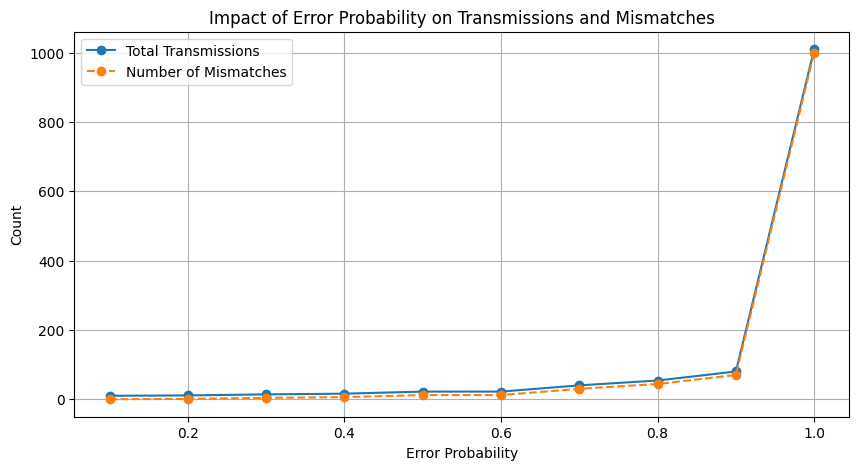

In [51]:
all_transmissions = []
all_mismatches = []
all_truetrans = []
error_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i in error_probs:
    transceiver = Transceiver()
    receiver = Receiver()
    # Adjusting the call to function based on correct error probability setup
    total_transmissions, num_mismatches, num_truetrans, acks , timeline= simulate_selective_repeat(
        transceiver, receiver, 4, 10, 20, i , 100 , 1
    )
    all_transmissions.append(total_transmissions)
    all_mismatches.append(num_mismatches)
    all_truetrans.append(num_truetrans)

# Creating the plot
plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(error_probs, all_transmissions , label='Total Transmissions', marker='o')

# Plotting number of mismatches
plt.plot(error_probs, all_mismatches, label='Number of Mismatches', marker='o', linestyle='--')

# Adding titles and labels
plt.title('Impact of Error Probability on Transmissions and Mismatches')
plt.xlabel('Error Probability')
plt.ylabel('Count')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()




Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Frame 0 transmitted successfully and acknowledged.
Ack0
Processing frame 1: Acknowledged=False, Attempts=0
Error introduced in frame 1 at position 11
Frame 1 transmission failed, retransmission required.
Nack1
Processing frame 2: Acknowledged=False, Attempts=0
Frame 2 transmitted successfully and acknowledged.
Ack2
Processing frame 3: Acknowledged=False, Attempts=0
Frame 3 transmitted successfully and acknowledged.
Ack3
Sliding window: Frame 0 acknowledged.

Window: 1 to 5
Processing frame 1: Acknowledged=False, Attempts=1
Frame 1 transmitted successfully and acknowledged.
Ack1
Processing frame 2: Acknowledged=True, Attempts=1
Processing frame 3: Acknowledged=True, Attempts=1
Processing frame 4: Acknowledged=False, Attempts=0
Error introduced in frame 4 at position 16
Frame 4 transmission failed, retransmission required.
Nack4
Sliding window: Frame 1 acknowledged.
Sliding window: Frame 2 acknowledged.
Sliding window: Fr

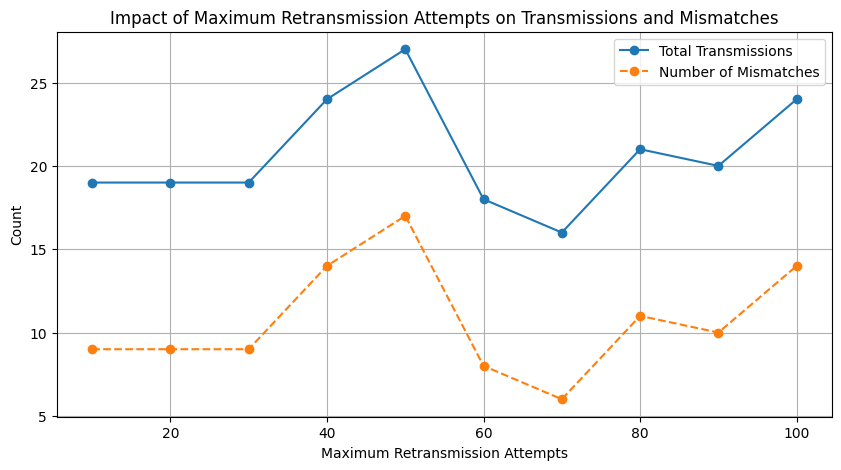

In [52]:
all_transmissions = []
all_mismatches = []
all_truetrans = []
max_attempts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for i in max_attempts:
    transceiver = Transceiver()
    receiver = Receiver()
    # Adjusting the call to function based on correct error probability setup
    total_transmissions, num_mismatches, num_truetrans, acks , timeline= simulate_selective_repeat(
        transceiver, receiver, 4, 10, 20, 0.5 , i , 1
    )
    all_transmissions.append(total_transmissions)
    all_mismatches.append(num_mismatches)
    all_truetrans.append(num_truetrans)

# Creating the plot
plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(max_attempts, all_transmissions , label='Total Transmissions', marker='o')

# Plotting number of mismatches
plt.plot(max_attempts, all_mismatches, label='Number of Mismatches', marker='o', linestyle='--')

# Adding titles and labels
plt.title('Impact of Maximum Retransmission Attempts on Transmissions and Mismatches')
plt.xlabel('Maximum Retransmission Attempts')
plt.ylabel('Count')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()



Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 13
Frame 0 transmission failed, retransmission required.
Nack0
Processing frame 1: Acknowledged=False, Attempts=0
Error introduced in frame 1 at position 5
Frame 1 transmission failed, retransmission required.
Nack1
Processing frame 2: Acknowledged=False, Attempts=0
Error introduced in frame 2 at position 16
Frame 2 transmission failed, retransmission required.
Nack2
Processing frame 3: Acknowledged=False, Attempts=0
Frame 3 transmitted successfully and acknowledged.
Ack3

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=1
Error introduced in frame 0 at position 16
Frame 0 transmission failed, retransmission required.
Nack0
Processing frame 1: Acknowledged=False, Attempts=1
Frame 1 transmitted successfully and acknowledged.
Ack1
Processing frame 2: Acknowledged=False, Attempts=1
Error introduced in frame 2 at position 14
Frame 2 transmission failed, retransmission r

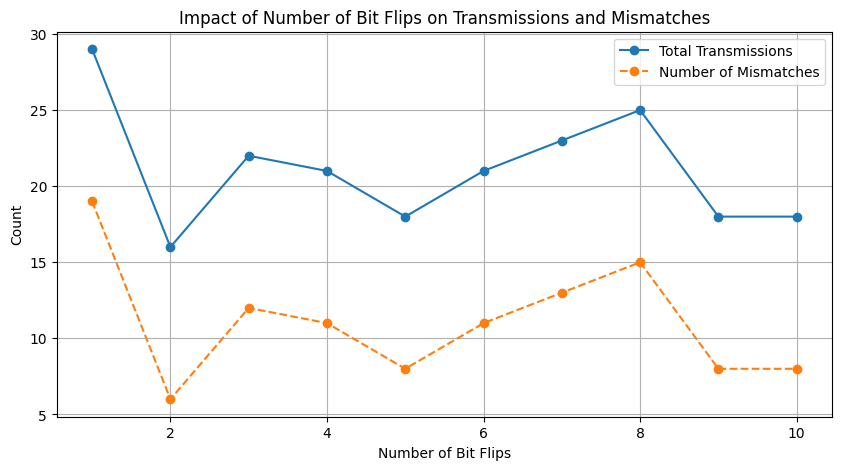

In [53]:
all_transmissions = []
all_mismatches = []
all_truetrans = []
bit_flips = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in bit_flips:
    transceiver = Transceiver()
    receiver = Receiver()
    # Adjusting the call to function based on correct error probability
    total_transmissions, num_mismatches, num_truetrans, acks , timeline= simulate_selective_repeat(
        transceiver, receiver, 4, 10, 20, 0.5 , 10 , i
    )
    all_transmissions.append(total_transmissions)
    all_mismatches.append(num_mismatches)
    all_truetrans.append(num_truetrans)
    
# Creating the plot
plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(bit_flips, all_transmissions , label='Total Transmissions', marker='o')

# Plotting number of mismatches
plt.plot(bit_flips, all_mismatches, label='Number of Mismatches', marker='o', linestyle='--')

# Adding titles and labels
plt.title('Impact of Number of Bit Flips on Transmissions and Mismatches')
plt.xlabel('Number of Bit Flips')
plt.ylabel('Count')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()

In [54]:
def showTime(timeline):
    frames = []
    types = []
    colors = []
    for entry in timeline:
        # Correctly separate text from number
        if entry.startswith('Ack'):
            frame_type = 'Ack'
            frame_number = int(entry[3:])  # Start from the 4th character
        else:
            frame_type = 'Nack'
            frame_number = int(entry[4:])  # Start from the 5th character
        
        frames.append(frame_number)
        types.append(frame_type)
        colors.append('green' if frame_type == 'Ack' else 'red')

    # Plotting
    plt.figure(figsize=(10, 2))  # Adjust the figure size as needed
    for i, frame in enumerate(frames):
        plt.scatter(i, 1, color=colors[i], marker='s', s=100)  # Use square markers

    # Formatting the plot
    plt.yticks([])  # Hide y-axis as it's not meaningful in this context
    plt.xticks(range(len(frames)), [f"{t}{f}" for t, f in zip(types, frames)], rotation=90)  # Show custom x-ticks with frame types
    plt.title('Timeline of ACKs and NACKs')
    plt.grid(True, axis='x')  # Show grid to better align the ticks

    plt.show()

code to show the timeline


Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 2
Frame 0 transmission failed, retransmission required.
Nack0
Processing frame 1: Acknowledged=False, Attempts=0
Error introduced in frame 1 at position 19
Frame 1 transmission failed, retransmission required.
Nack1
Processing frame 2: Acknowledged=False, Attempts=0
Error introduced in frame 2 at position 20
Frame 2 transmission failed, retransmission required.
Nack2
Processing frame 3: Acknowledged=False, Attempts=0
Frame 3 transmitted successfully and acknowledged.
Ack3

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=1
Error introduced in frame 0 at position 7
Frame 0 transmission failed, retransmission required.
Nack0
Processing frame 1: Acknowledged=False, Attempts=1
Error introduced in frame 1 at position 1
Frame 1 transmission failed, retransmission required.
Nack1
Processing frame 2: Acknowledged=False, Attempts=1
Error introduced in frame 2 at position 17


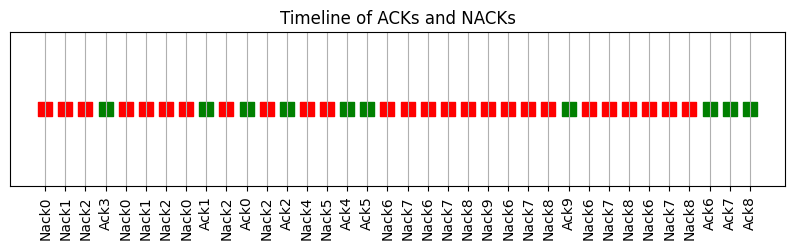

In [55]:
transceiver = Transceiver()
receiver = Receiver()
# Adjusting the call to function based on correct error probability setup
total_transmissions, num_mismatches, num_truetrans, acks , timeline= simulate_selective_repeat(
    transceiver, receiver, 4, 10, 20, 0.8 , 10 , 1
)

print(f"\nTotal Transmissions: {total_transmissions}")
print(f"Number of Mismatches: {num_mismatches}")
print(f"Number of Successful Transmissions: {num_truetrans}")
print("Acknowledgment Status:", acks)
print("Timeline:", timeline)

showTime(timeline)


code to simulate stop and wait

In [56]:
def simulate_stopAndWait(transceiver, receiver, num_streams, stream_length, error_probability, missmax, number_of_flips):
    total_transmissions = 0
    num_mismatches = 0
    num_truetrans = 0
    original_streams = [stream.copy() for stream in transceiver.crc_appended_streams]  # Make a copy of the original streams
    acks = [False] * num_streams  # Track acknowledgment status
    timeline = []
    
    i = 0
    max_miss = 0
    while i < num_streams:
        # Get the last transmitted stream
        stream = original_streams[i].copy()

        # Introduce error with a given probability
        if random.random() < error_probability and max_miss < missmax:
            flipped_bits = set()
            while len(flipped_bits) < number_of_flips:
                bit_to_flip = random.randint(0, len(stream) - 33)  # excluding the CRC bits
                if bit_to_flip not in flipped_bits:
                    stream[bit_to_flip] = 1 - stream[bit_to_flip]  # Flip the bit
                    flipped_bits.add(bit_to_flip)
            print(f"Error introduced in frame {i} at positions {flipped_bits}")
        else:
            stream = original_streams[i].copy()

        # Transmit and check
        valid = receiver.add_stream(stream)
        total_transmissions += 1
        if not valid:
            num_mismatches += 1
            max_miss += 1
            timeline.append("Nack" + str(i))
            acks[i] = False
        else:
            num_truetrans += 1
            acks[i] = True
            timeline.append("Ack" + str(i))
            i += 1  # Move to the next stream only if the current one is successfully transmitted
            max_miss = 0

    return total_transmissions, num_mismatches, num_truetrans, acks, timeline


code to test stop and wait

Error introduced in frame 0 at positions {16}
Error introduced in frame 0 at positions {18}
Error introduced in frame 0 at positions {4}
Error introduced in frame 0 at positions {13}
Error introduced in frame 0 at positions {13}
Error introduced in frame 0 at positions {12}
Error introduced in frame 1 at positions {6}
Error introduced in frame 1 at positions {9}
Error introduced in frame 1 at positions {4}
Error introduced in frame 3 at positions {7}
Error introduced in frame 3 at positions {9}
Error introduced in frame 3 at positions {13}
Error introduced in frame 4 at positions {14}
Error introduced in frame 5 at positions {3}
Error introduced in frame 9 at positions {2}
Error introduced in frame 9 at positions {13}
Error introduced in frame 9 at positions {9}
Error introduced in frame 9 at positions {19}
Error introduced in frame 9 at positions {7}
Error introduced in frame 9 at positions {10}
Error introduced in frame 9 at positions {8}

Total Transmissions: 31
Number of Mismatches

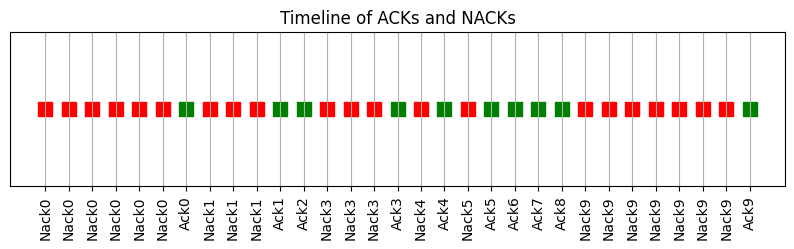

In [57]:
transceiver = Transceiver()
receiver = Receiver()
for _ in range(10):
    transceiver.process_stream(20)
stopTotal_transmissions , stopNum_mismatches , stopNum_truetrans , stopAcks , stopTimeline = simulate_stopAndWait(
    transceiver, receiver, 10, 20, 0.6,100,1
)
print(f"\nTotal Transmissions: {stopTotal_transmissions}")
print(f"Number of Mismatches: {stopNum_mismatches}")
print(f"Number of Successful Transmissions: {stopNum_truetrans}")
print("Acknowledgment Status:", stopAcks)
print("Timeline:", stopTimeline)

showTime(stopTimeline)


Window: 0 to 1
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 17
Frame 0 transmission failed, retransmission required.
Nack0

Window: 0 to 1
Processing frame 0: Acknowledged=False, Attempts=1
Error introduced in frame 0 at position 8
Frame 0 transmission failed, retransmission required.
Nack0

Window: 0 to 1
Processing frame 0: Acknowledged=False, Attempts=2
Error introduced in frame 0 at position 1
Frame 0 transmission failed, retransmission required.
Nack0

Window: 0 to 1
Processing frame 0: Acknowledged=False, Attempts=3
Error introduced in frame 0 at position 15
Frame 0 transmission failed, retransmission required.
Nack0

Window: 0 to 1
Processing frame 0: Acknowledged=False, Attempts=4
Frame 0 transmitted successfully and acknowledged.
Ack0
Sliding window: Frame 0 acknowledged.

Window: 1 to 2
Processing frame 1: Acknowledged=False, Attempts=0
Frame 1 transmitted successfully and acknowledged.
Ack1
Sliding window: Frame 1 acknowledged.


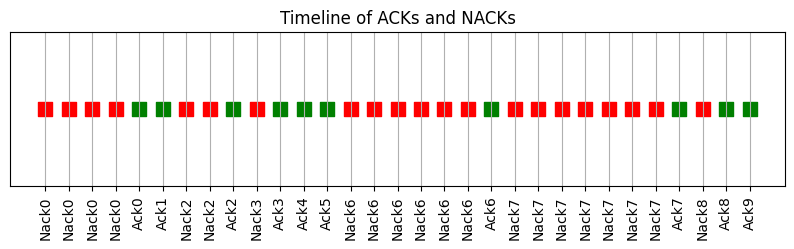

In [58]:
SRtotal_transmissions, SRnum_mismatches, SRnum_truetrans, SRacks, SRtimeline = simulate_selective_repeat(
    transceiver, receiver, 1, 10, 20, 0.6, 100, 1
)

showTime(SRtimeline)


method to apply go back N

In [59]:
def simulate_go_back_n(transceiver, receiver, window_size, num_streams, stream_length, error_probability, max_attempts, number_of_flips):
    total_transmissions = 0
    num_mismatches = 0
    num_truetrans = 0
    
    # Initialize the frames in the transceiver
    if len(transceiver.crc_appended_streams) == 0:
        for _ in range(num_streams):
            transceiver.process_stream(stream_length)

    original_streams = [stream.copy() for stream in transceiver.crc_appended_streams]  # Make a copy of the original streams

    acks = [False] * num_streams  # Track acknowledgment status
    attempts = [0] * num_streams  # Track transmission attempts for each frame

    smin = 0  # Start of the window
    smax = smin + window_size  # End of the window

    timeline = []
    while smin < num_streams:
        print(f"\nWindow: {smin} to {min(smax, num_streams - 1)}")
        for j in range(smin, min(smax, num_streams)):
            print(f"Processing frame {j}: Acknowledged={acks[j]}, Attempts={attempts[j]}")
            if not acks[j]:  # Check if not acknowledged and less than max attempts
                stream = original_streams[j].copy()
                if random.random() < error_probability and attempts[j] < max_attempts:
                    flipped_bits = set()
                    while len(flipped_bits) < number_of_flips:
                        bit_to_flip = random.randint(0, len(stream) - 33)  # Ensure not flipping CRC bits
                        if bit_to_flip not in flipped_bits:
                            stream[bit_to_flip] = 1 - stream[bit_to_flip]
                            flipped_bits.add(bit_to_flip)
                            print(f"Error introduced in frame {j} at position {bit_to_flip}")

                # Transmitting the frame
                valid = receiver.add_stream(stream)
                total_transmissions += 1
                attempts[j] += 1

                if valid:
                    acks[j] = True
                    num_truetrans += 1
                    print(f"Frame {j} transmitted successfully and acknowledged.")
                    timeline.append("Ack" + str(j))
                else:
                    num_mismatches += 1
                    print(f"Frame {j} transmission failed, retransmission required.")
                    timeline.append("Nack" + str(j))
                    # If a frame fails, reset the window start to this frame and all subsequent frames need resending
                    acks[smin : smax] = [False] * (smax - smin)
                    break  # Exit the inner loop to start resending from the failed frame

        # Move the window
        while smin < num_streams and acks[smin]:
            print(f"Sliding window: Frame {smin} acknowledged.")
            smin += 1
            smax = smin + window_size

    return total_transmissions, num_mismatches, num_truetrans, acks, timeline



Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 18
Frame 0 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=1
Error introduced in frame 0 at position 3
Frame 0 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=2
Error introduced in frame 0 at position 1
Frame 0 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=3
Error introduced in frame 0 at position 15
Frame 0 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=4
Frame 0 transmitted successfully and acknowledged.
Processing frame 1: Acknowledged=False, Attempts=0
Error introduced in frame 1 at position 1
Frame 1 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=5
Error introduc

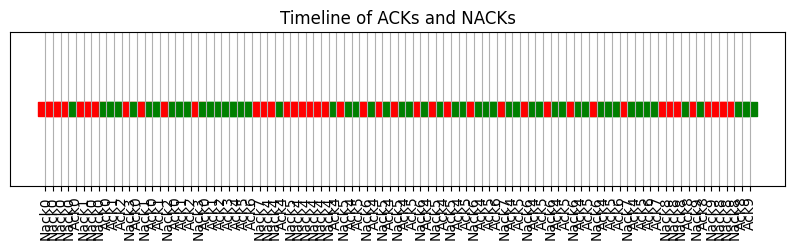

In [62]:
gobackTotal_transmissions, gobackNum_mismatches, gobackNum_truetrans, gobackAcks, gobackTimeline = simulate_go_back_n(
    transceiver, receiver, 4, 10, 20, 0.6, 10, 1
)

print(f"\nTotal Transmissions: {gobackTotal_transmissions}")
print(f"Number of Mismatches: {gobackNum_mismatches}")
print(f"Number of Successful Transmissions: {gobackNum_truetrans}")
print("Acknowledgment Status:", gobackAcks)
print("Timeline:", gobackTimeline)

showTime(gobackTimeline)
    

Error introduced in frame 0 at positions {17}
Error introduced in frame 8 at positions {18}

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 0
Frame 0 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=1
Frame 0 transmitted successfully and acknowledged.
Processing frame 1: Acknowledged=False, Attempts=0
Frame 1 transmitted successfully and acknowledged.
Processing frame 2: Acknowledged=False, Attempts=0
Frame 2 transmitted successfully and acknowledged.
Processing frame 3: Acknowledged=False, Attempts=0
Frame 3 transmitted successfully and acknowledged.
Sliding window: Frame 0 acknowledged.
Sliding window: Frame 1 acknowledged.
Sliding window: Frame 2 acknowledged.
Sliding window: Frame 3 acknowledged.

Window: 4 to 8
Processing frame 4: Acknowledged=False, Attempts=0
Frame 4 transmitted successfully and acknowledged.
Processing frame 5: Acknowledged=False, Attempts=0


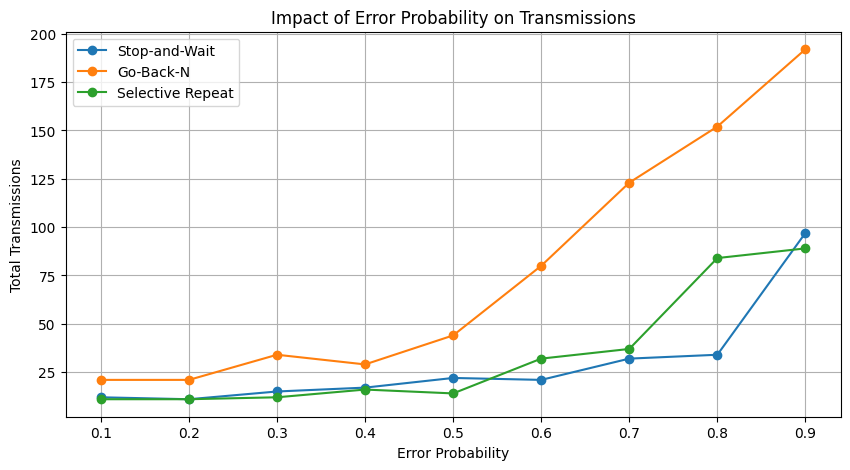

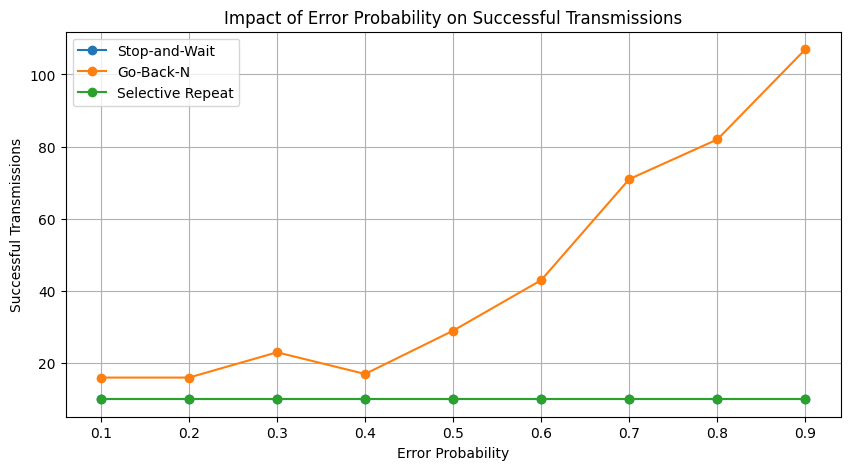

In [63]:
error_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
allStop_transmissions = []
allStop_mismatches = []
allStop_truetrans = []
allgo_transmissions = []
allgo_mismatches = []
allgo_truetrans = []
allSr_transmissions = []
allSr_mismatches = []
allSr_truetrans = []
for i in error_probs:
    transceiver = Transceiver()
    receiver = Receiver()
    # Adjusting the call to function based on correct error probability setup

    for _ in range(10):
        transceiver.process_stream(20)

    stopTotal_transmissions , stopNum_mismatches , stopNum_truetrans , stopAcks , stopTimeline = simulate_stopAndWait(
    transceiver, receiver, 10, 20, i,100,1
    )
    allStop_transmissions.append(stopTotal_transmissions)
    allStop_mismatches.append(stopNum_mismatches)
    allStop_truetrans.append(stopNum_truetrans)
    goTotal_transmissions , goNum_mismatches , goNum_truetrans , goAcks , goTimeline = simulate_go_back_n(
    transceiver, receiver, 4, 10, 20, i, 10, 1
    )
    allgo_transmissions.append(goTotal_transmissions)
    allgo_mismatches.append(goNum_mismatches)
    allgo_truetrans.append(goNum_truetrans)
    SRtotal_transmissions, SRnum_mismatches, SRnum_truetrans, SRacks, SRtimeline = simulate_selective_repeat(
    transceiver, receiver, 1, 10, 20, i, 100, 1
    )
    allSr_transmissions.append(SRtotal_transmissions)
    allSr_mismatches.append(SRnum_mismatches)
    allSr_truetrans.append(SRnum_truetrans)

# Creating the plot
plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(error_probs, allStop_transmissions , label='Stop-and-Wait', marker='o')
plt.plot(error_probs, allgo_transmissions , label='Go-Back-N', marker='o')
plt.plot(error_probs, allSr_transmissions , label='Selective Repeat', marker='o')

# Adding titles and labels
plt.title('Impact of Error Probability on Transmissions')
plt.xlabel('Error Probability')
plt.ylabel('Total Transmissions')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()

plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(error_probs, allStop_truetrans , label='Stop-and-Wait', marker='o')
plt.plot(error_probs, allgo_truetrans , label='Go-Back-N', marker='o')
plt.plot(error_probs, allSr_truetrans , label='Selective Repeat', marker='o')

# Adding titles and labels
plt.title('Impact of Error Probability on Successful Transmissions')
plt.xlabel('Error Probability')
plt.ylabel('Successful Transmissions')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()

Error introduced in frame 1 at positions {7}
Error introduced in frame 1 at positions {10}
Error introduced in frame 2 at positions {1}
Error introduced in frame 3 at positions {19}
Error introduced in frame 3 at positions {1}
Error introduced in frame 3 at positions {11}
Error introduced in frame 3 at positions {12}
Error introduced in frame 4 at positions {6}
Error introduced in frame 6 at positions {18}
Error introduced in frame 8 at positions {15}
Error introduced in frame 8 at positions {4}
Error introduced in frame 9 at positions {16}
Error introduced in frame 9 at positions {8}

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=0
Error introduced in frame 0 at position 12
Frame 0 transmission failed, retransmission required.

Window: 0 to 4
Processing frame 0: Acknowledged=False, Attempts=1
Frame 0 transmitted successfully and acknowledged.
Processing frame 1: Acknowledged=False, Attempts=0
Error introduced in frame 1 at position 13
Frame 1 transmission failed, ret

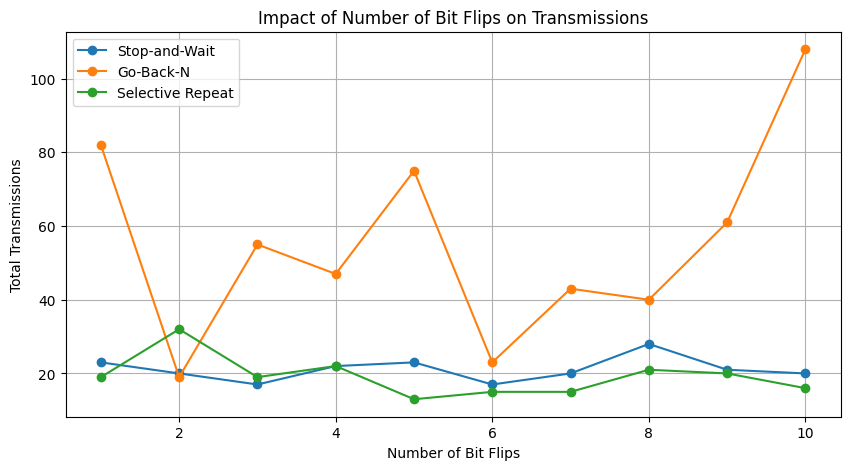

In [142]:
bit_flips = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
allStop_transmissions = []
allStop_mismatches = []
allStop_truetrans = []
allgo_transmissions = []
allgo_mismatches = []
allgo_truetrans = []
allSr_transmissions = []
allSr_mismatches = []
allSr_truetrans = []
for i in bit_flips:
    transceiver = Transceiver()
    receiver = Receiver()
    # Adjusting the call to function based on correct error probability setup

    for _ in range(10):
        transceiver.process_stream(20)

    stopTotal_transmissions , stopNum_mismatches , stopNum_truetrans , stopAcks , stopTimeline = simulate_stopAndWait(
    transceiver, receiver, 10, 20, 0.5,100,i
    )
    allStop_transmissions.append(stopTotal_transmissions)
    allStop_mismatches.append(stopNum_mismatches)
    allStop_truetrans.append(stopNum_truetrans)
    goTotal_transmissions , goNum_mismatches , goNum_truetrans , goAcks , goTimeline = simulate_go_back_n(
    transceiver, receiver, 4, 10, 20, 0.5, 10, i
    )
    allgo_transmissions.append(goTotal_transmissions)
    allgo_mismatches.append(goNum_mismatches)
    allgo_truetrans.append(goNum_truetrans)
    SRtotal_transmissions, SRnum_mismatches, SRnum_truetrans, SRacks, SRtimeline = simulate_selective_repeat(
    transceiver, receiver, 1, 10, 20, 0.5, 100, i
    )
    allSr_transmissions.append(SRtotal_transmissions)
    allSr_mismatches.append(SRnum_mismatches)
    allSr_truetrans.append(SRnum_truetrans)

# Creating the plot
plt.figure(figsize=(10, 5))

# Plotting total transmissions
plt.plot(bit_flips, allStop_transmissions , label='Stop-and-Wait', marker='o')
plt.plot(bit_flips, allgo_transmissions , label='Go-Back-N', marker='o')
plt.plot(bit_flips, allSr_transmissions , label='Selective Repeat', marker='o')

# Adding titles and labels
plt.title('Impact of Number of Bit Flips on Transmissions')
plt.xlabel('Number of Bit Flips')
plt.ylabel('Total Transmissions')
plt.legend()

# Showing the grid
plt.grid(True)